# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;                        Projeto 3 - Ciência dos Dados
___
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; **André Nadalini, Guilherme Lotaif, João Zsigmond e Kamila Wansa**

<br>

## 1. Problema: Análise de dados de lutas da UFC


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Este projeto tem como objetivo principal a análise de dados com grau elevado de autonomia. Para fazer a mesma, pegamos nossa base de dados através do site [kaggle](https://www.kaggle.com), que contém diferentes datasets com conteúdos variados. 

Por meio da análise de dados, pretendemos responder à pergunta:<br>
#### Dado dois jogadores e suas características, quem tem a maior chance de ganhar a luta?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para responder a esta pergunta é preciso pensar em diversos aspectos. Com isso em mente iremos analisar um dataset do UFC contendo aproximadamente a documentação de 5000 lutas, que possui diferentes características tanto do jogador do <font color='red'>Red corner</font>, quanto do <font color='blue'>Blue corner</font>.

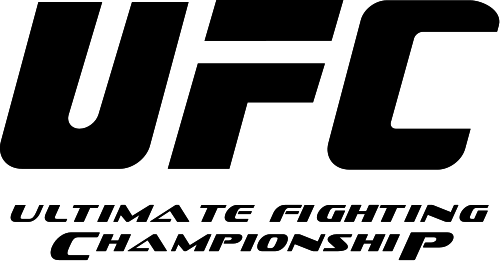

___


### 1.1. Preparação para a análise:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para efetuarmos o estudo, temos que abrir e corrigir possíveis problemas que podem atrapalhar nossa análise. Com isso em mente vamos primeiro arrumar as colunas categóricas.

**Importando as bibliotecas**

In [2]:
import warnings
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

**Importando as bases de dados**

In [3]:
#Importando o arquivo de treinamento:
data = pd.read_csv("./ufcdata/data.csv")

In [4]:
#Vamos ver um exemplo do nosso dataframe:
data.head(5)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


...
<br>

Para evitar erros no codigo vamos averiguar por possíveis dados nulos, que caso existam terão que ser eliminados. 

In [5]:
dados_nulos = data.isnull().sum().sum()
print("O dataset possui um total de {0} valores nulos.".format(dados_nulos))

O dataset possui um total de 95390 valores nulos.


In [6]:
#Vamos eliminar os dados nulos:
data.dropna(inplace=True)
data = data.truncate(0, 3500)

...
<br>

### Corrigindo itens na tabela:<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para fazermos a análise e o classificador de maneira mais eficaz temos que corrigir pequenos problemas que poderão nos atrapalhar no futuro, portanto vamos criar colunas novas com parte dos dados coletados de outras colunas categóricas.


In [7]:
#Criando uma coluna para os países extraídos da coluna de localização:
data['country'] = data['location'].apply(lambda x : x.split(',')[-1])

#Criando uma coluna com os anos extraídos da coluna de data:
data['year'] = data['date'].apply(lambda x : x.split('-')[0])

<br>

Agora vamos separar o lutador perdedor do vencedor.

In [8]:
#Vamos Criar um dataframe para as vitorias de "Red" e "Blue":
red_wins_data = data.loc[data.Winner == "Red"]
red_lose_data = data.loc[data.Winner == "Blue"]

...


#### Vamos criar um dataframe relativo

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para fazer a classificação, decidimos fazer um dataframe relativo uma vez que este analisa os dados, já que com ele, saberemos a relação entre os dois jogadores para uma mesma variável qualitativa. Com isso, a função ***get_relevant_dictionary***, cria um dicionário onde as chaves são os nomes das colunas cujos valores pertencem ao lutador "R", e os valores são as colunas cujos valores pertencem ao lutador "B". 

Ex.: { "R_fighter" : "B_fighter" }. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Já a função ***create_relative_df*** cria um novo dataframe, no qual as colunas são as variáveis quantitativas, e as linhas são a razão entre os valores do lutador do foo <font color='red'>RED corner</font> foo pelo do lutador do foo <font color='blue'>BLUE corner</font>. 

In [9]:
def get_relevant_dictionary(df):
    dic = {}
    colunas = df.columns.values;
    for name in colunas:
        if name[0] == "R" and name != "Referee":
            oposer_name = "B"+name[1:]
            dic[name] = oposer_name
    return(dic)

In [10]:
data_preprocessed = pd.read_csv("./ufcdata/preprocessed_data.csv")
data_preprocessed["win"] = 0
data_preprocessed.loc[data_preprocessed.Winner == "Red", "win"] = 1

wins = data_preprocessed["win"]

In [11]:
def create_relative_df(data, relevant_categories):
    dic = {}
    for R_value, B_value in relevant_categories.items():
        if type(data[R_value].iloc[1]) == np.float64:
            dic["{}".format(R_value[2:])] = (data[R_value] / data[B_value])
    relative_df = pd.DataFrame(dic)
    return relative_df


relevant_categories = get_relevant_dictionary(data_preprocessed)
relative_df = create_relative_df(data_preprocessed, relevant_categories)

relative_df["win"] = wins

relative_df.drop(columns= ["current_lose_streak","draw"], inplace = True)
relative_df.head(2)

,current_win_streak,avg_BODY_att,avg_BODY_landed,avg_CLINCH_att,avg_CLINCH_landed,avg_DISTANCE_att,avg_DISTANCE_landed,avg_GROUND_att,avg_GROUND_landed,avg_HEAD_att,...,win_by_Decision_Unanimous,win_by_KO/TKO,win_by_Submission,win_by_TKO_Doctor_Stoppage,wins,Height_cms,Reach_cms,Weight_lbs,age,win
0,1.000000,2.380435,2.733333,85.000000,inf,1.198083,1.286408,3.615385,3.250000,1.526749,...,inf,1.0,0.0,NaN,2.00,0.969697,0.955224,1.0,1.032258,1
1,0.666667,0.821918,0.847724,0.786925,0.939335,0.706839,0.858500,7.678571,8.646617,0.755102,...,2.0,NaN,inf,0.0,1.25,0.984848,1.000000,1.0,0.968750,1


In [12]:
relative_total_rounds = np.array(relative_df['total_rounds_fought'])
relative_total_rounds = relative_total_rounds.reshape(-1, 1)

___
<br>

## 2. Análise Exploratória:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para que possamos definir quais colunas de características são as mais importantes para a implementação do metodo de predição, temos que analisar os dados no dataframe e discutir a importância de seus resultados.


...
<br>

**Quantas disputas registradas são por títulos?**<br>
Para sabermos a importância de cada luta, é importante saber se existem muitas lutas com disputa por títulos, ou se estas ocorrem com menor frequência.

In [13]:
#Vamos descobrir a quantidade:
bout_ = data.title_bout.value_counts()

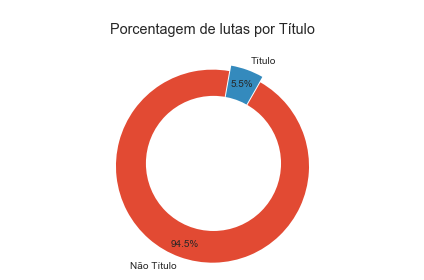

In [14]:
# Vamos nomear as partes:
labels = ['Não Título', 'Título']
sizes = bout_.values
# Vamos "explodir" somente um pedaço:
explode = (0.03,0.03)
#Fornecendo as caracteristicas do gráfico:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=80,
        pctdistance=0.85, explode = explode)
#Criando o Círculo:
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Vamos definir o aspecto de circulo, portanto "equal":
ax1.axis('equal')
plt.title("\nPorcentagem de lutas por Título\n")
plt.tight_layout()
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O gráfico acima mostar a relação entre as lutas em que há disputa por títulos e as que não. Com base nele, conseguimos perceber que a maioria delas não os envolvem, o que mostra que existe uma diferença considerável de nível entre as lutas, considerando que as que envolvem um título possivelmente possuem lutadores mais reconhecidos, enquanto as outras mais variados.  

...
<br>

**Qual será a frequência de vitórias por corner?** 

In [15]:
#Vamos descobrir a quantidade:
winner_1 = data.Winner.value_counts()

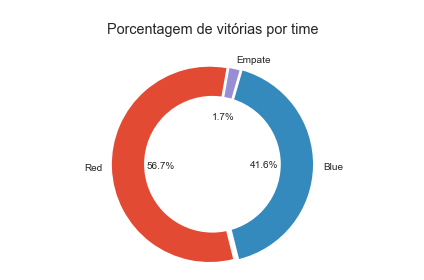

In [16]:
# Vamos nomear as partes:
labels = ['Red', 'Blue',"Empate"]
sizes = winner_1.values
# Vamos "explodir" somente um pedaço:
explode = (0.03,0.03,0)
#Fornecendo as caracteristicas do gráfico:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=80,
        pctdistance=0.50, explode = explode)
#Criando o Círculo:
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Vamos definir o aspecto de circulo, portanto "equal":
ax1.axis('equal')
plt.title("\nPorcentagem de vitórias por time\n")
plt.tight_layout()
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Analisando o gráfico acima notamos que a maioria das vitórias foram do corner vermelho, assim surge uma preocupação com relação ao impacto desse dado no modelo usado para predição que pode acabar usando a cor como um fator significante.

...
<br>

**Será que existe um país no qual as lutas ocorrem mais vezes?**

In [17]:
#Vamos descobrir a quantidade:
loc_1 = data.country.value_counts().head(15)

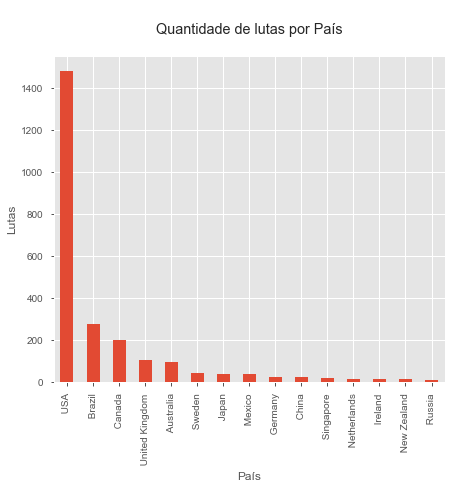

In [18]:
#Criando uma tabela com os dados:)
plot = loc_1.plot(kind='bar', figsize=(7, 6), align='center')
plt.title("\nQuantidade de lutas por País\n")
plt.xticks(rotation=90)
plt.ylabel('Lutas')
plt.xlabel('País')
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A célula acima traz também uma problematização com relação ao dataset. Isso porque a grande maioria das lutas foram realizadas nos EUA, assim, lutadores do país ou de paises com características semelhantes ao mesmo poderiam ter vantagem com relação aos outros. Dessa forma, o dataset falha em apresentar um possível fator significante.

Correlações: 
Vitória do Vermelho: 0.02 
Vitória do Azul:     0.11


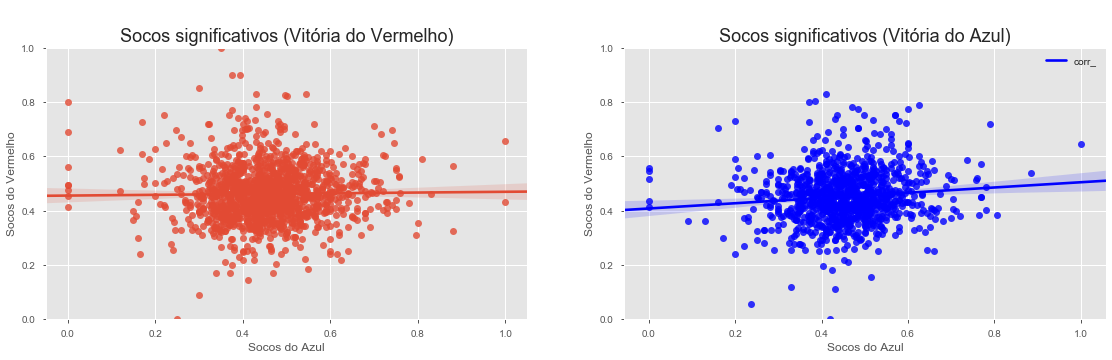

In [20]:
#Fornecendo as caracteristicas do gráfico:
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
#Criando um "scatterplot" com uma bissetriz:
ax0 = sns.regplot(x=red_wins_data.B_avg_SIG_STR_pct, y=red_wins_data.R_avg_SIG_STR_pct,
                      data=data)
plt.title("\nSocos significativos (Vitória do Vermelho)",size=18)
plt.ylabel('Socos do Vermelho')
plt.xlabel('Socos do Azul')
ax0.set(ylim=(0,1))
#Fornecendo as caracteristicas do gráfico:
plt.subplot(122)
#Criando um scatterplot" com uma bissetriz:
ax1 = sns.regplot(x=red_lose_data.B_avg_SIG_STR_pct, y=red_lose_data.R_avg_SIG_STR_pct,color="blue",
                      data=data)
plt.legend([str('corr_strikes_blue')[:5]])
plt.title("\nSocos significativos (Vitória do Azul)",size=18)
plt.ylabel('Socos do Vermelho')
plt.xlabel('Socos do Azul')
ax1.set(ylim=(0,1))
#Descobrindo as correlações mostrando os resultados:
corr_strikes_blue = red_lose_data.B_avg_SIG_STR_pct.corr(red_lose_data.R_avg_SIG_STR_pct)
corr_strikes_red = red_wins_data.B_avg_SIG_STR_pct.corr(red_wins_data.R_avg_SIG_STR_pct)
print("Correlações:","\nVitória do Vermelho: {:.2f}".format(corr_strikes_red)
                    ,"\nVitória do Azul:     {:.2f}".format(corr_strikes_blue))

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Com base nos gráficos de dispersão, é possível perceber que a porcentagem dos socos significativos na carreira de cada jogador está concentrada em um mesmo intervalo, próximo de 0.5. Além disso, conclui-se que a medida é pouco relevante para a análise dos resultados finais, já que os dados estão concentrados em torno do meio do gráfico, indicando que os valores de ambos os lutadores (azul e vermelho) em uma luta são muito próximos, não podendo, assim, representar a diferença entre vencer ou perder. 

<br>

Vamos analisar a mesma variável através de histogramas:


AZUL GANHA


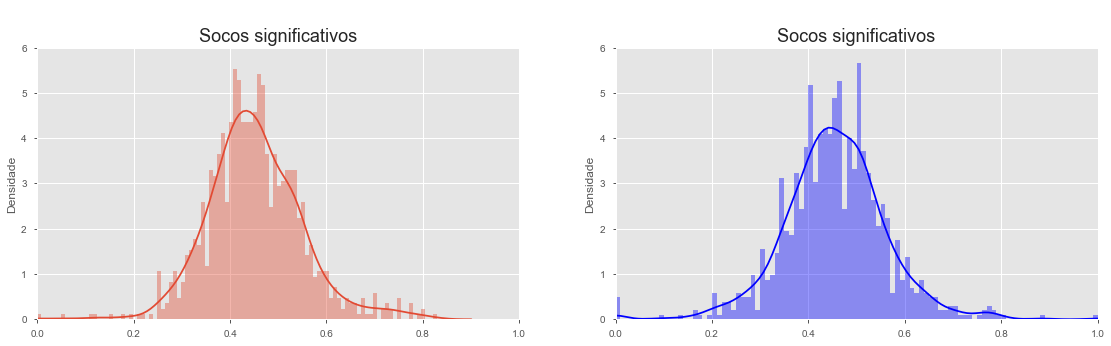

VERMELHO GANHA


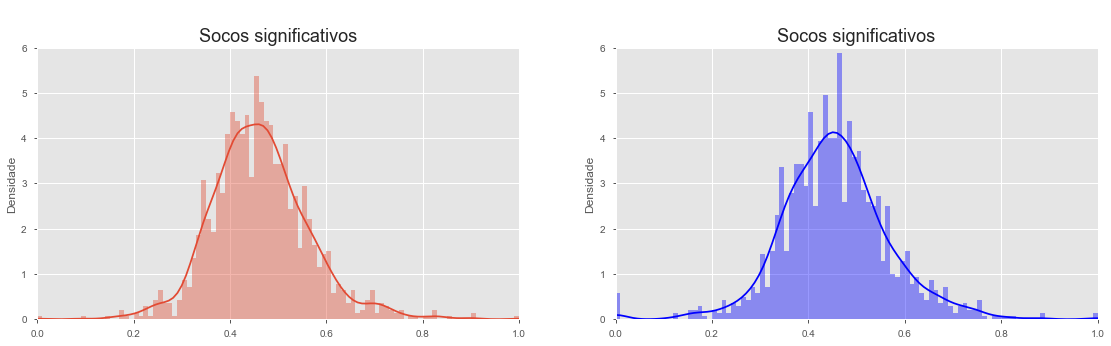

In [21]:
#Fornecendo as caracteristicas do gráfico:
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
print("\nAZUL GANHA")
#Criando um histograma:
ax2 = sns.distplot(red_lose_data.R_avg_SIG_STR_pct, bins = 100)
plt.title("\nSocos significativos",size=18)
plt.ylabel('Densidade')
plt.xlabel('')
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))

plt.subplot(122)
#Criando um histograma:
ax2 = sns.distplot(red_lose_data.B_avg_SIG_STR_pct, bins = 100, color="b")
plt.title("\nSocos significativos",size=18)
plt.ylabel('Densidade')
plt.xlabel('')
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))
plt.show()

fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
print("VERMELHO GANHA")
#Criando um histograma:
ax2 = sns.distplot(red_wins_data.R_avg_SIG_STR_pct, bins = 100)
plt.title("\nSocos significativos",size=18)
plt.ylabel('Densidade')
plt.xlabel('')
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))

plt.subplot(122)
#Criando um histograma:
ax2 = sns.distplot(red_wins_data.B_avg_SIG_STR_pct, bins = 100, color="b")
plt.title("\nSocos significativos",size=18)
plt.ylabel('Densidade')
plt.xlabel('')
ax2.set(xlim=(0,1))
ax2.set(ylim=(0,6))
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Analisando agora os histogramas dessa mesma variável, consegue-se notar que há uma variação, por mais que pequena, entre os valores de cada um, vermelho e azul, quando o azul é o vencedor e quando o vermelho ganha. Os dados dos lutadores azuis vencedores, comparados com os azuis perdedores, por exemplo, estão levemente deslocados para a direita. No entanto, vale reforçar que a mudança é sutil, o que não faz essa característica assumir, sozinha, grande importância.

...
<br>

#### Será que existe diferença no ataque em solo entre o ganhador e o perderdor?

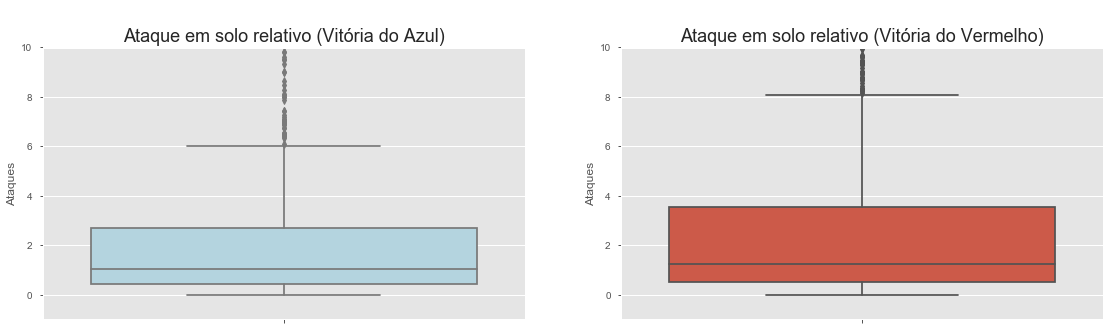

In [39]:
#Fornecendo as caracteristicas do gráfico:
fig = plt.figure(figsize=(19, 5))
plt.subplot(121)
#Criando um boxplot:
ax = sns.boxplot(y=relative_df.avg_GROUND_att.loc[relative_df.win== 0], color="lightblue");
ax.set(ylim=(-1,10))
plt.title("\nAtaque em solo relativo (Vitória do Azul)",size=18)
plt.ylabel("Ataques")

plt.subplot(122)
#Criando um boxplot:
ax = sns.boxplot(y=relative_df.avg_GROUND_att.loc[relative_df.win== 1]);
ax.set(ylim=(-1,10))
plt.title("Ataque em solo relativo (Vitória do Vermelho)",size=18)
plt.ylabel("Ataques")
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O boxplot acima mostra a quantidade de ataques no chão relativa (vermelho dividido por azul) das lutas quando o azul ganha e quando o vermelho ganha. Analisando-os pode-se ver que, apesar de as medianas de ambos os casos estarem próximas, quando o azul ganha, o primeiro quartil chega a valores mais próximos de zero, o que mostra que os lutadores azuis neste caso chegam a ter valores relativamente maiores em relação aos adversários do que os lutadores azuis quando o vermelho ganha. O contrário também é observado, quando o vermelho ganha a proporção entre vermelho e azul chega a valores bem mais altos do que a proporção quando o azul ganha, fato que pode ser observado pelas alturas dos terceiro e quarto quartis, que são visivelmente mais altas no segundo caso. Ou seja, esta variável tende a ser relativamente mais alta no grupo de vencedores, sendo considerada signifcante para a amostra.

...
<br>

#### Agora vamos ver se existe influência na luta gerada por vitórias consecutivas:

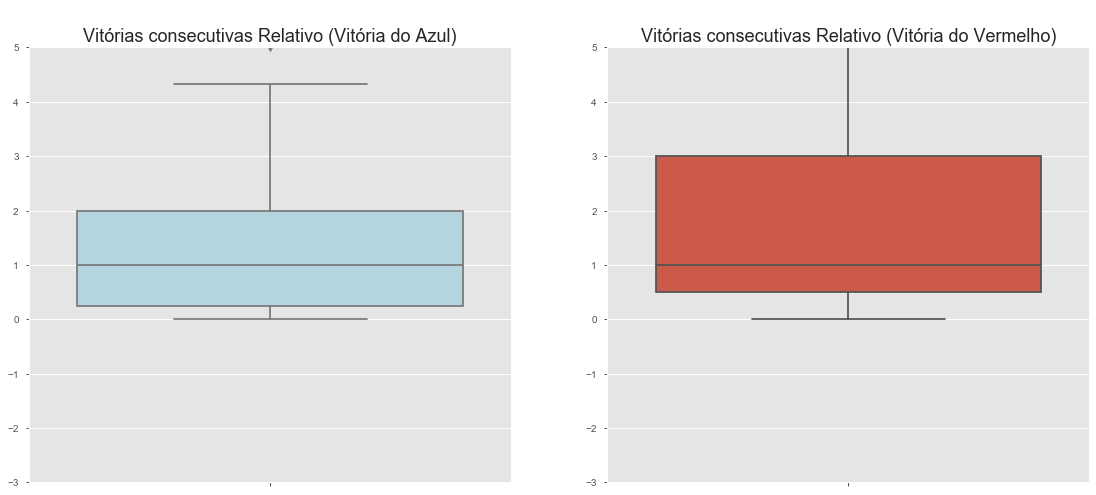

In [23]:
#Fornecendo as caracteristicas do gráfico:
fig = plt.figure(figsize=(19, 8))
plt.subplot(121)
#Criando um boxplot:
ax = sns.boxplot(y=relative_df.current_win_streak.loc[relative_df.win == 0], color="lightblue")
ax.set(ylim=(-3,5))
plt.title("\nVitórias consecutivas Relativo (Vitória do Azul)",size=18)
plt.ylabel("")

plt.subplot(122)
#Criando um boxplot:
ax = sns.boxplot(y=relative_df.current_win_streak.loc[relative_df.win== 1])
ax.set(ylim=(-3,5))
plt.title("Vitórias consecutivas Relativo (Vitória do Vermelho)",size=18)
plt.ylabel("")
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O boxplot acima mostra a distribuição do streak de vitórias relativo (vermelho dividido pelo azul). Novamente, pode-se ver que as medianas estão no mesmo ponto (1), o que mostra que a variável streak de vitórias tende a ser equilibrada entre os dois lutadores. No entanto, os quartis superiores quando o vermelho ganha alcançam alturas maiores do que quando o azul ganha, mostrando que os vermelhos que ganham costumam ter proporções mais altas em relação ao adversário do que os vermelhos perdedores. O mesmo observa-se no contrário, já que a divisão dos quartis inferiores fica mais próxima de zero qual o azul ganha (azuis tendem a ser proporcionalmente maiores). Dessa forma, pode-se considerar o win streak relevante para a predição.

...
<br>

#### Vamos avaliar furos na defesa dos lutadores:

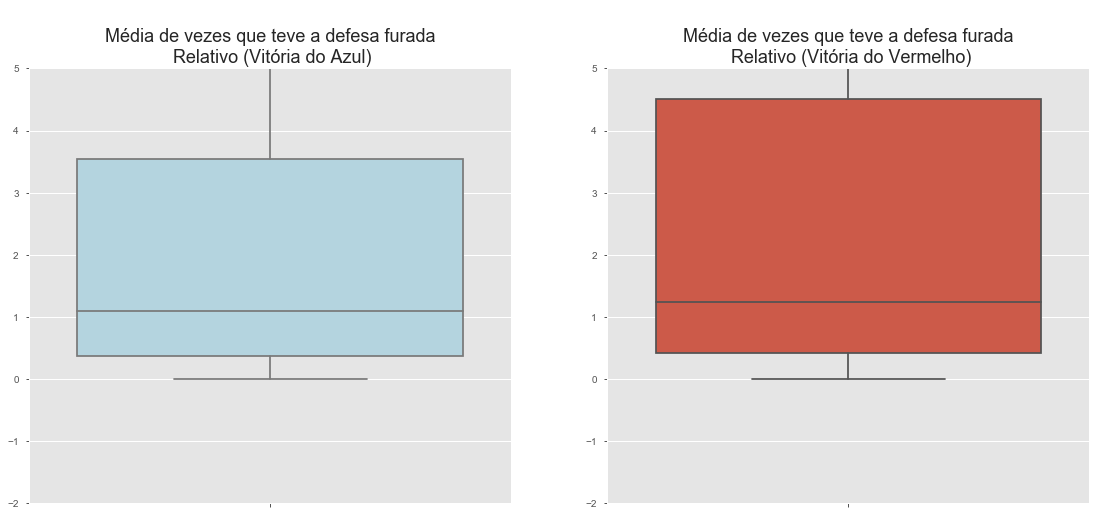

In [24]:
#Fornecendo as caracteristicas do gráfico:
fig = plt.figure(figsize=(19, 8))
plt.subplot(121)
#Criando um boxplot:
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win == 0], color="lightblue")
ax.set(ylim=(-2,5))
plt.title("\nMédia de vezes que teve a defesa furada\n Relativo (Vitória do Azul)",size=18)
plt.ylabel("")

plt.subplot(122)
#Criando um boxplot:
ax = sns.boxplot(y=relative_df.avg_PASS.loc[relative_df.win== 1])
ax.set(ylim=(-2,5))
plt.title("Média de vezes que teve a defesa furada\n Relativo (Vitória do Vermelho)",size=18)
plt.ylabel("")
plt.show()

A mesma análise feita nos boxplots anteriores pode ser feita no mostrado acima. No entanto, a diferença é menos acentuada nesta variável, sendo considerada menos significante.

...
<br>

Agora vamos fazer a mesma análise através de um gráfico de dispersão.

Correlações: 
Vitória do Vermelho: 0.11 
Vitória do Azul:     0.13


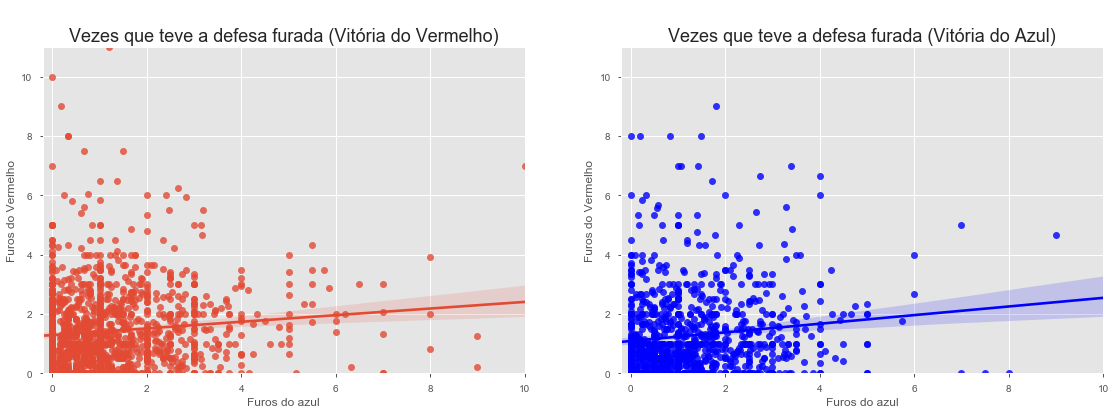

In [25]:
#Fornecendo as caracteristicas do gráfico:
fig = plt.figure(figsize=(19, 6))
plt.subplot(121)
#Criando um scatterplot" com uma bissetriz:
ax0 = sns.regplot(x=red_wins_data.B_avg_PASS, y=red_wins_data.R_avg_PASS,
                      data=red_wins_data)
plt.title("\nVezes que teve a defesa furada (Vitória do Vermelho)",size=18)
plt.ylabel('Furos do Vermelho')
plt.xlabel('Furos do azul')
ax0.set(ylim=(0,11))
ax0.set(xlim=(-0.2,10))

plt.subplot(122)
#Criando um scatterplot" com uma bissetriz:
ax1 = sns.regplot(x=red_lose_data.R_avg_PASS, y=red_lose_data.B_avg_PASS,color="blue",
                      data=red_lose_data)
plt.title("\nVezes que teve a defesa furada (Vitória do Azul)",size=18)
plt.ylabel('Furos do Vermelho')
plt.xlabel('Furos do azul')
ax1.set(ylim=(0,11))
ax1.set(xlim=(-0.2,10))

corr_pass_blue = red_lose_data.R_avg_PASS.corr(red_lose_data.B_avg_PASS)
corr_pass_red = red_wins_data.R_avg_PASS.corr(red_wins_data.B_avg_PASS)

print("Correlações:","\nVitória do Vermelho: {:.2f}".format(corr_pass_red)
                    ,"\nVitória do Azul:     {:.2f}".format(corr_pass_blue))

Pode-se ver que o gráfico de dispersão não é tão eificiente no caso em questão já que as diferenças são sutis e tem muitas medidas.

...


### • Análise pelo Pandas Profiling:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Esta função normalmente é usada quando queremos fazer uma análise exploratória um pouco mais completa e de maneira rapida e intuitiva. Tal método funciona de maneira que quando a função é chamada, ela cria uma análise dos dados do Dataframe através do pandas.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para o nosso projeto esta ferramenta foi excelente, devido ao fato que a mesma faz correlações entre diversas variáveis e ainda nos fornece plots das variáveis analisadas.

A ferramenta requer uma intalação:

**PIP INSTALL**<br>
Para instalar através do PIP, use o comando:

`pip install pandas-profiling`

**CONDA INSTALL**<br>
Para isntalar através do Conda, use o comando:

`conda install -c anaconda pandas-profiling`

<br>

In [26]:
import pandas_profiling

In [27]:
#pandas_profiling.ProfileReport(data)

___
<br>

## 3. Implementação dos metodos de predição.

<br>
Primeiro Vamos organizar o dataframe da melhor maneira para termos o melhor resultado possível.

In [28]:
win = np.array(relative_df["win"])
win = win.ravel()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
        relative_total_rounds, win, test_size=0.33, random_state=42)

...
<br><br>

**`Classificador KNN:`**

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
knn_y_pred = knn.predict(X_test)

In [32]:
metrics.accuracy_score(y_test, knn_y_pred)

0.6205733558178752

...
<br><br>

**`Classificador GNB:`**

In [33]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [34]:
gnb_y_pred = gnb.predict(X_test)
metrics.accuracy_score(y_test, gnb_y_pred)

0.6652613827993255

...
<br><br>

**`Classificador Random Forest:`**

In [35]:
rfst = RandomForestClassifier()
rfst.fit(X_train, y_train);

C:\Users\W10\Anaconda3.7\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:
rfst_y_pred = rfst.predict(X_test)
metrics.accuracy_score(y_test, rfst_y_pred)

0.6011804384485666

...
<br><br>

**`Classificador MLP:`**

In [37]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)
metrics.accuracy_score(y_test, mlp_y_pred)

0.6669477234401349

**`Classificador XGB:`**

Um outro classificador que obteve acurácia de 67%. Ultiliza-se um método de "Gradient Boosting". É o método que ultilizamos no nosso aplicativo de predição.

___
<br>

## 4. Conclusão:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O nosso dataframe não possuia diversas informações importantes para avaliar o desempenho de cada jogador, como por exemplo o incentivo financeiro, o local da luta , por exemplo se foi no local de nascimento de um dos jogadores, que pode afetar no sentimento de apoio e acolhimento por parte plateia.
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Além disso, como estamos analisando valores relativos entre dois lutadores, de forma que as características em questão são semelhantes, muitas vezes pode acontecer de serem valores bastante próximos, reduzindo assim a variabilidade, quando se tratando de apenas poucas variáveis. Por outro lado, quando analisamos muitas variáveis, que é o caso do nosso datasheet, pode ser possível perceber uma maior variação do conjunto de forma a prever com maior acurácia o resultado. 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Outro fator que pode ter afetado o resultado, é que muitas vezes há outras características dos jogadores menos concretas que podem avaliar o seu desempenho na luta e que não estão relacionadas ao físico ou algo do tipo, como por exemplo o psicológico do lutador no momento da luta, ou seu preparo prévio. 
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ademais, utilizamos dados relativos, da razão entre a diferença dos valores de ambos sobre o segundo, de forma que também podemos refletir se essa de fato foi a melhor maneira de fazer essa análise e retornar o melhor resultado possível. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Por fim, como destacado ao longo da nossa análise de dados e reforçado aqui, o nosso dataset, por mais que com diversas variáveis, possivelmente não continha outros aspectos importantes tanto para o entendimento dos resultados observados quanto para a análise dos dados, que pode ter afetado o desempenho da nossa predição, que se aproxima de 67% de acurácia.  


## Trabalho em equipe: ##
   De forma geral, o trabalho em equipe foi bem equilibrado. Cada membro desenvolveu um papel essencial  no trabalho, cada um com sua função e seu ponto forte. O João Zsigmond, criou grande parte do código dos classificadores, do servidor e do site. O restante do grupo focou mais na parte da análise exploratória dos dados, documentação do código e escrita dos objetivos, perguntas e conclusões. No entanto, todos ajudaram em todos os quesitos.

  Houveram poucos commits no github, já que estavamos trabalhando em um mesmo dataset e qualquer alteração poderia causar conflito.

___
<br>

## 5. Referências Bibliográficas:

- https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
- https://seaborn.pydata.org/